<a href="https://colab.research.google.com/github/navant/decluttr/blob/main/src/notebooks/decluttr-exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM finds Wally



In [1]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib chromadb open-clip-torch python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 3.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━

##  Setting up API keys

In the left panel, select the key symbol and input your secret keys. You will need GOOGLE_API_KEY with an access to Gemini-pro-vision.

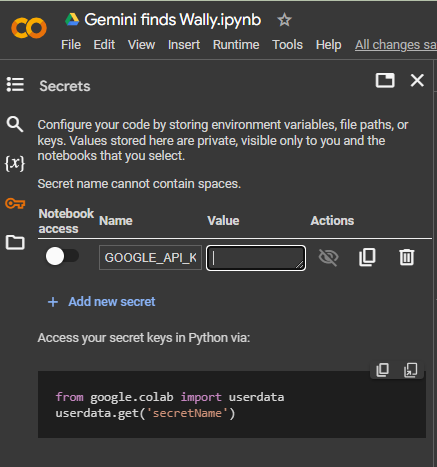

Please refer to the Google Python quickstart for more details: https://ai.google.dev/tutorials/python_quickstart

In [10]:
import textwrap

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path = '/workspaces/decluttr/decluttr-app/backend/.env', override=True)
GOOGLE_API_KEY = os.environ['GOOGLE_API_KEY']

## Some helper functions to display images

### Plot a series of images given their filepaths

In [11]:
## Plot images helper function

from PIL import Image
import matplotlib.pyplot as plt
import os

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


### Compress images

In [12]:
from PIL import Image
import os

def compress_image(image_path, max_size):


  # Open the image
  with Image.open(image_path) as img:
      # Calculate the size in bytes
      size = os.path.getsize(image_path)
      print('Image ', image_path, ' has size ', size)
      if size > max_size:
          # Compute the compression ratio
          ratio = (max_size / size) ** 0.5
          new_dimensions = (int(img.width * ratio), int(img.height * ratio))

          # Create the compressed image path
          root, ext = os.path.splitext(image_path)
          compressed_path = f"{root}_compressed{ext}"
          print('...compressing into ', compressed_path)

          # Resize the image
          img = img.resize(new_dimensions, Image.ANTIALIAS)

          # Save the compressed image
          img.save(compressed_path, optimize=True, quality=85)
      else:
          compressed_path = image_path

  return compressed_path

### Plot one large image

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

def display_large_image(image_path):
    """
    Display an image given the image path, with a large size in a Jupyter notebook.

    :param image_path: Path to the image file.
    """
    # Open the image
    img = Image.open(image_path)

    # Display the image using matplotlib
    plt.figure(figsize=(16, 16))  # You can adjust the size as needed
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

## Load target and sources images

In [25]:
# Load target and source images

from PIL import Image
import requests
from io import BytesIO

from llama_index.schema import ImageDocument
from typing import Literal

TARGET_FOLDER='targets'
SOURCE_FOLDER='sources'

targets_name_url = [('wally', 'https://steemitimages.com/DQmYEFMCdofVgxRf1VnDYSG9ejxop4wtjCU3B383dEC9tKW/WALLY.png'),
                         ('wally', 'https://metro.co.uk/wp-content/uploads/2016/03/pm_25817756.jpg?quality=90&strip=all&zoom=1&resize=540%2C1056'),
('wally girl', 'https://www.vhv.rs/dpng/d/225-2256117_wheres-wally-the-fantastic-journey-wheres-waldo-wizard.png'),
('doggy',  'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/70138307/3/?bust=1703362531&width=720'),
('demon',  'https://i.pinimg.com/originals/5c/11/14/5c111438124efdfe67e3c76bbe61025d.jpg')]

sources_name_url = [('beach', 'https://wallpapercave.com/wp/wp7156925.jpg'),
 ('snow easy', 'https://wallpapercave.com/wp/wp7156958.png'), ('vikings', 'https://wallpapercave.com/wp/wp7156934.jpg')]

def save_image_url_and_create_image_document_with_metadata(image_type: Literal['source', 'target'], name_urls, image_folder):
  # save images
  if not os.path.exists(image_folder):
      os.makedirs(image_folder)

  image_documents = []
  for idx, tupl in enumerate(name_urls):
      image_url=tupl[1]
      name = tupl[0]
      print(idx, tupl)
      response = requests.get(image_url)
      img = Image.open(BytesIO(response.content))
      image_path=f"{image_folder}/{name}-{idx}.png"
      print(image_path)
      img.save(image_path)

      image_path = compress_image(image_path, 2 * 1024 * 1024)

      metadata = {"name": name, "image_type": image_type}

      image_documents.append(ImageDocument(image_path=image_path, metadata=metadata))

  return image_documents

target_image_documents = save_image_url_and_create_image_document_with_metadata('target', targets_name_url, TARGET_FOLDER)
source_image_documents = save_image_url_and_create_image_document_with_metadata('source', sources_name_url, SOURCE_FOLDER)

0 ('wally', 'https://steemitimages.com/DQmYEFMCdofVgxRf1VnDYSG9ejxop4wtjCU3B383dEC9tKW/WALLY.png')
targets/wally-0.png
Image  targets/wally-0.png  has size  441448
1 ('wally', 'https://metro.co.uk/wp-content/uploads/2016/03/pm_25817756.jpg?quality=90&strip=all&zoom=1&resize=540%2C1056')
targets/wally-1.png
Image  targets/wally-1.png  has size  370833
2 ('wally girl', 'https://www.vhv.rs/dpng/d/225-2256117_wheres-wally-the-fantastic-journey-wheres-waldo-wizard.png')
targets/wally girl-2.png
Image  targets/wally girl-2.png  has size  268676
3 ('doggy', 'https://dl5zpyw5k3jeb.cloudfront.net/photos/pets/70138307/3/?bust=1703362531&width=720')
targets/doggy-3.png
Image  targets/doggy-3.png  has size  243219
4 ('demon', 'https://i.pinimg.com/originals/5c/11/14/5c111438124efdfe67e3c76bbe61025d.jpg')
targets/demon-4.png
Image  targets/demon-4.png  has size  938396
0 ('beach', 'https://wallpapercave.com/wp/wp7156925.jpg')
sources/beach-0.png
Image  sources/beach-0.png  has size  1939491
1 ('sno

<ipython-input-12-0f26dd1d8443>:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(new_dimensions, Image.ANTIALIAS)


2 ('vikings', 'https://wallpapercave.com/wp/wp7156934.jpg')
sources/vikings-2.png
Image  sources/vikings-2.png  has size  6477164
...compressing into  sources/vikings-2_compressed.png


## Initialize `GeminiMultiModal`

* Leveraging Gemini for the image reasoning


In [14]:
import google.generativeai as genai
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)



List available Gemini Models from `google.generativeai`.
Make sure your API key has access to models

In [14]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


In [15]:
from google.generativeai.types import GenerationConfig, GenerationConfigType

gemini_generation_config = GenerationConfig(1, temperature=0, top_p=1, top_k=32)

# what is temperature, top_p, top_k : see https://docs.cohere.com/docs/controlling-generation-with-top-k-top-p


## Prompt gemini to find Wally

In [64]:
from typing import Any, Sequence
from llama_index.llms.types import (CompletionResponse)
from llama_index.multi_modal_llms import GeminiMultiModal

from llama_index.llms.gemini_utils import completion_from_gemini_response

class CustomGeminiMultiModal(GeminiMultiModal):
    """
    Custom Gemini multimodal class.

    This class extends GeminiMultiModal with a custom complete method to pass the following prompt structure to Gemini
    [start_of_prompt, *target_images, end_of_prompt, *source_images]

    Note: the standard complete methods only sends the text prompt, followed by the images.
    """

    def complete(
        self, prompt: str, image_documents: Sequence[ImageDocument], **kwargs: Any
    ) -> CompletionResponse:
        source_images = [Image.open(doc.resolve_image()) for doc in image_documents if doc.metadata.get("image_type") == 'source']
        target_images = [Image.open(doc.resolve_image()) for doc in image_documents if doc.metadata.get("image_type") == 'target']
        print('Number of source images:', len(source_images))
        print('Number of target images:', len(target_images))
        start_of_prompt = prompt_template_str.split("{target}")[0]
        print('start of prompt:', start_of_prompt)
        end_of_prompt = "\nSource:"
        result = self._model.generate_content([start_of_prompt, *target_images, end_of_prompt, *source_images], **kwargs)
        return completion_from_gemini_response(result)



In [18]:
custom_gemini_llm = CustomGeminiMultiModal(
    api_key=GOOGLE_API_KEY,
    model_name="models/gemini-pro-vision",
    generation_congfig=gemini_generation_config
)

gemini_llm = GeminiMultiModal(
    api_key=GOOGLE_API_KEY,
    model_name="models/gemini-pro-vision",
    generation_congfig=gemini_generation_config
)


In [19]:
# define source and target

image_documents = [target_image_documents[0], source_image_documents[2]]


In [20]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser
from llama_index.schema import ImageDocument

prompt_template_str = """\
Below you will be given 2 images, a "target" and a "source". The target may be contained in the source. Locate the target in the source.

Output format:
If no target found in the image: reply "target not found in the source"
If target found: give the approximate position of the target in the source, using the coordinate system starting at (0,0) in the top left corner and (100%, 100%) in the bottom right corner.
Describe with precision other entities at the top, left, right and bottom of the target.

Target:
{target}

Source:
{source}
"""

llm_response = gemini_llm.complete(prompt=prompt_template_str, image_documents=image_documents)



In [21]:
llm_response

CompletionResponse(text=" Target: \nMan with red and white striped shirt, brown hair, glasses, brown shoes, and a brown cane. He is waving with his right hand and has a brown bag over his shoulder.\n\nSource:\nA Where's Waldo image of a bunch of people on boats in the ocean.\n\nThe target is in the source at (40%, 50%). \nAbove the target is a man in a red and white striped shirt, brown hair, and glasses. He is holding a fishing pole. \nTo the left of the target is a woman in a red and white striped shirt, brown hair, and glasses. She is holding a fishing pole. \nTo the right of the target is a man in a blue shirt and brown hair. He is holding a fishing pole. \nBelow the target is a mermaid with red hair and a green tail. She is holding a fishing pole.", additional_kwargs={}, raw={'content': {'parts': [{'text': " Target: \nMan with red and white striped shirt, brown hair, glasses, brown shoes, and a brown cane. He is waving with his right hand and has a brown bag over his shoulder.\n\n

In [22]:
custom_llm_response = custom_gemini_llm.complete(prompt=prompt_template_str, image_documents=image_documents)
custom_llm_response

Number of source images: 1
Number of target images: 1
start of prompt: Below you will be given 2 images, a "target" and a "source". The target may be contained in the source. Locate the target in the source.

Output format:
If no target found in the image: reply "target not found in the source" 
If target found: give the approximate position of the target in the source, using the coordinate system starting at (0,0) in the top left corner and (100%, 100%) in the bottom right corner. 
Describe with precision other entities at the top, left, right and bottom of the target. 

Target: 



CompletionResponse(text=' The target is located at the bottom of the source, slightly to the left. The target is wearing a red and white striped shirt, glasses, and a red hat with a white pom pom. The target is holding a brown cane in his right hand and a brown bag with a strap over his shoulder. To the left of the target is a mermaid holding a pink fish. To the right of the target is a man with a brown beard wearing a yellow shirt and blue pants. Above the target is a group of people in a red boat. Below the target is a sandy ocean floor with various sea creatures.', additional_kwargs={}, raw={'content': {'parts': [{'text': ' The target is located at the bottom of the source, slightly to the left. The target is wearing a red and white striped shirt, glasses, and a red hat with a white pom pom. The target is holding a brown cane in his right hand and a brown bag with a strap over his shoulder. To the left of the target is a mermaid holding a pink fish. To the right of the target is a m

# Result of finding Wally

['targets/wally-0.png', 'sources/vikings-2_compressed.png']


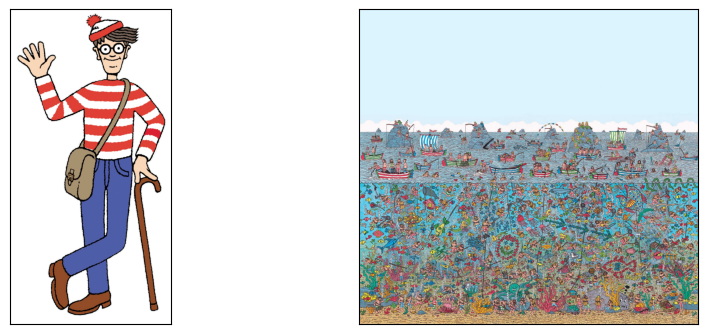

In [23]:
image_paths = [str(img_doc.image_path) for img_doc in image_documents]
print(image_paths)
plot_images(image_paths)

sources/vikings-2_compressed.png


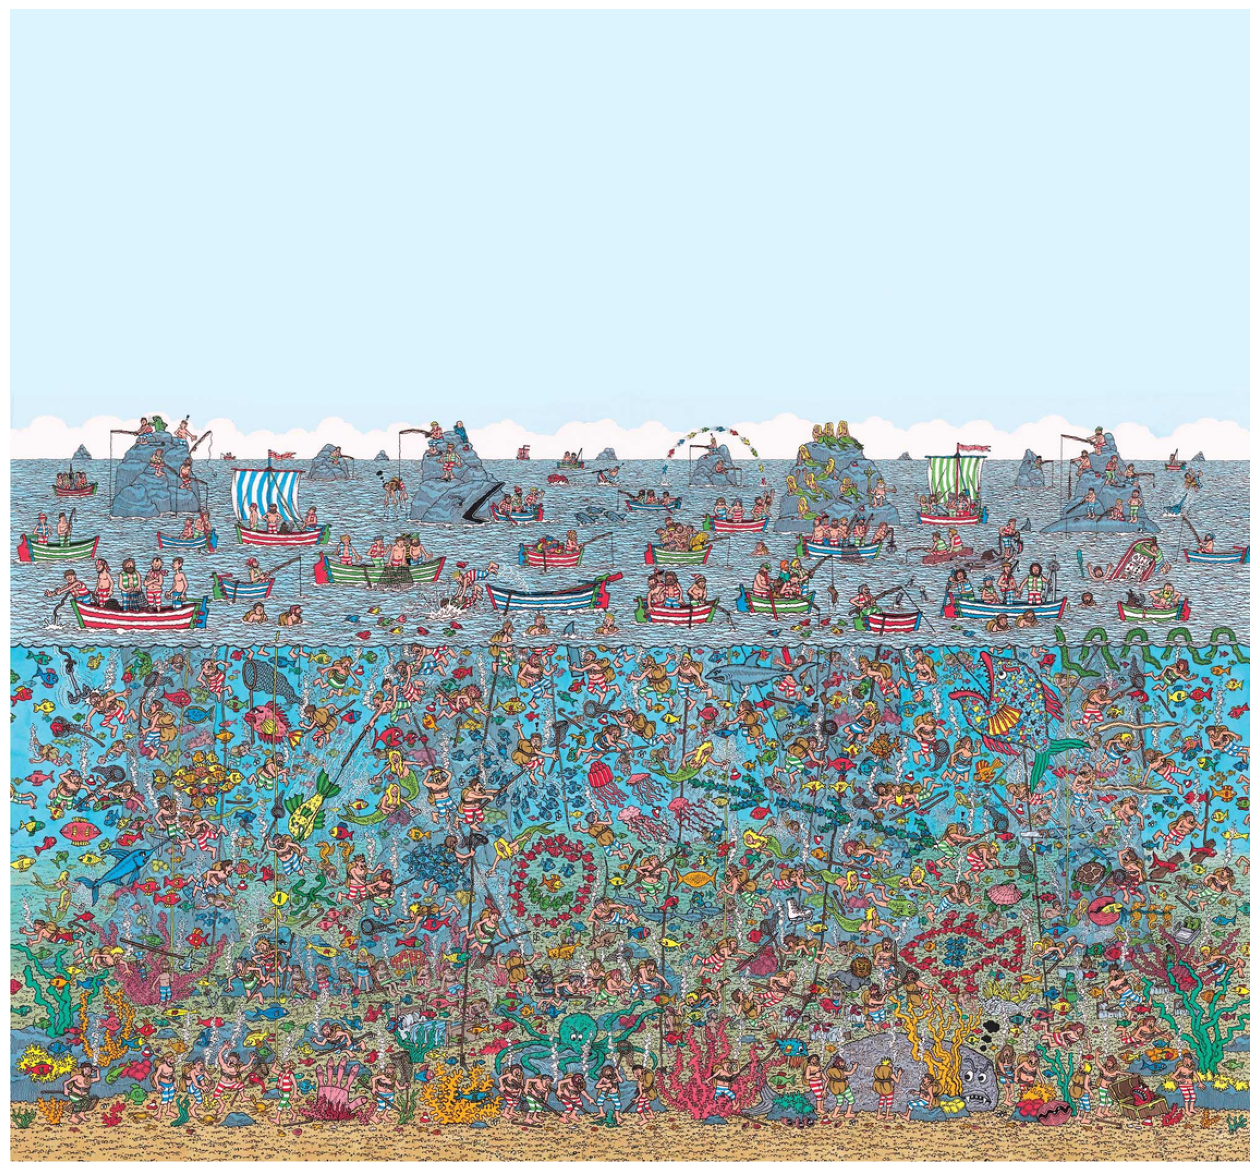

In [23]:



print(image_paths[1])
display_large_image(image_paths[1])

In [26]:
custom_llm_response.text

' The target is located at the bottom of the source, slightly to the left. The target is wearing a red and white striped shirt, glasses, and a red hat with a white pom pom. The target is holding a brown cane in his right hand and a brown bag with a strap over his shoulder. To the left of the target is a mermaid holding a pink fish. To the right of the target is a man with a brown beard wearing a yellow shirt and blue pants. Above the target is a group of people in a red boat. Below the target is a sandy ocean floor with various sea creatures.'

In [ ]:
llm_response.text

## 3rd Part: Build Multi-Modal RAG for context about the target

This time, we won't give the image of the target. We will just talk about the target, hope our retrieval technique will bring back the right image and then ask gemini to locate that image in the source.  



### Get the LLM to describe targets so that we can store them in vector store, image and description included.

### View targets

['targets/wally-0.png', 'targets/wally-1.png', 'targets/wally girl-2.png', 'targets/doggy-3.png', 'targets/demon-4.png']


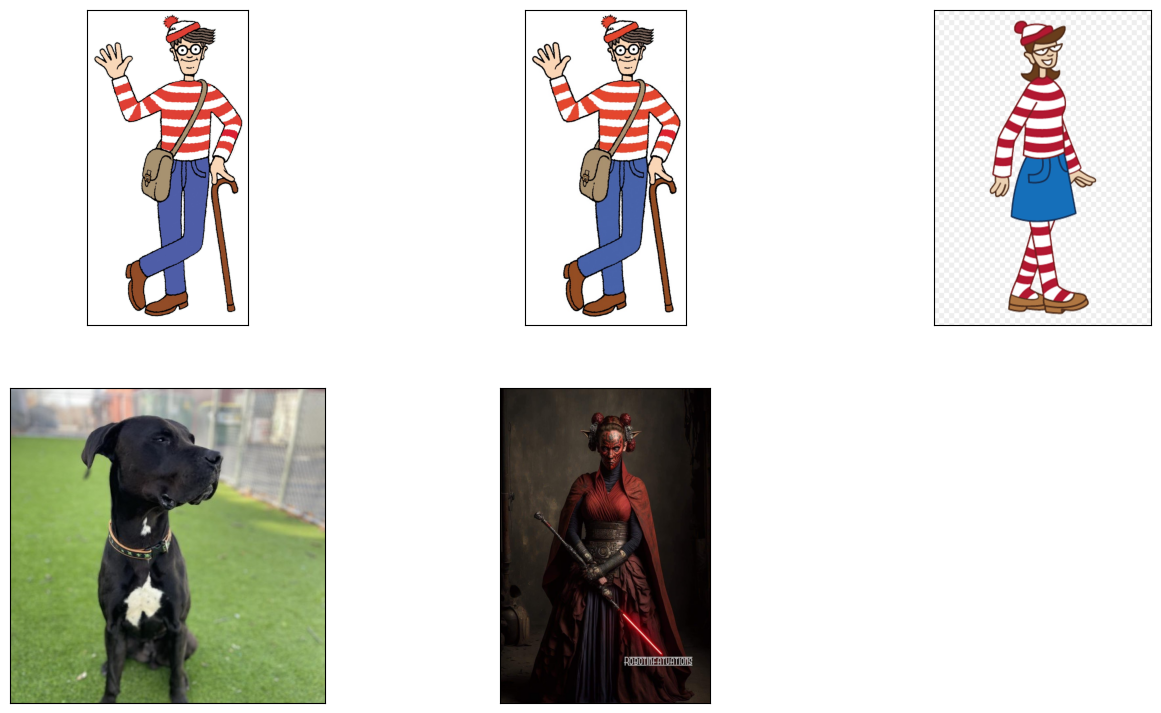

In [27]:
import matplotlib.pyplot as plt
from llama_index.response.notebook_utils import display_image_uris

image_paths = [str(img_doc.image_path) for img_doc in target_image_documents]
print(image_paths)
plot_images(image_paths)

In [28]:
describe_entity_prompt_template = "Start by stating the following sentence: 'This is {name}'. Then describe the main entity presented in the image with rich details. Don't invent anything"
describe_entity_prompt_template = "Say who's in the image. If they are popular characters state their name and who they are. Then describe them in the image with rich details. Don't invent anything"


describe_entity_prompt_template = """
Identify the person, animal or object in the image.
First state the name:
-If the subject in the image is a known person or animal from popular culture, please state their name and origin.
-If the subject is not a widely recognized individual, please identify it generically (e.g., 'This is a bag of cashew nuts,' 'This is a dog')
Then describe the character or entity with detailed accuracy.

Image Description:

The subject is positioned centrally in the frame.
Provide a detailed description of the subject's physical appearance, including height, build, hair color, eye color, and any distinguishing features.
Describe the clothing or accessories, if any, with specific attention to colors, styles, and any logos or symbols.
Note the background setting, whether it's indoors or outdoors, and any relevant objects or scenery that might provide contextual information about the subject.
If applicable, describe the subject's posture or expression, and how it might convey their mood or character traits.
"""

In [29]:
for target_image_document in target_image_documents:
  name = target_image_document.metadata["name"]
  print('Name:', name, ', image_path:', target_image_document.image_path)
  description = gemini_llm.complete(prompt=describe_entity_prompt_template.format(name=name), image_documents=[target_image_document])
  print('... description:', description.text)
  target_image_document.text = description.text

Name: wally , image_path: targets/wally-0.png
... description:  The image shows a man standing with a cane in his left hand and his right hand raised in the air. He is wearing a red and white striped shirt, blue pants, and brown shoes. He has a brown bag hanging from his right shoulder. He is wearing glasses and a red and white hat with a pom-pom on the end. He has a friendly expression on his face.

The man is standing in a green field. There are no other people or objects in the image.

The man is likely to be Wally, also known as Waldo, from the children's picture book series "Where's Wally?" by Martin Handford. Wally is a bespectacled man who wears a red-and-white-striped shirt and a red-and-white bobble hat. He is known for being very good at hiding, and the reader is challenged to find him in each picture.
Name: wally , image_path: targets/wally-1.png
... description:  The image shows a man standing with a cane in his left hand and waving with his right hand. He is wearing a red 

### Embed target images and their description

In [30]:
import tqdm as notebook_tqdm

In [31]:
# https://docs.llamaindex.ai/en/latest/examples/multi_modal/ChromaMultiModalDemo.html#

from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

# set defalut text and image embedding functions
embedding_function = OpenCLIPEmbeddingFunction()

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [32]:
# create client and a new collection
import chromadb
from chromadb.utils.data_loaders import ImageLoader

image_loader = ImageLoader()

chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection(
    "multimodal_collection",
    embedding_function=embedding_function,
    data_loader=image_loader,
)

In [35]:
# set up ChromaVectorStore and load in data
from llama_index.vector_stores import ChromaVectorStore
from llama_index.indices import VectorStoreIndex
from llama_index import StorageContext

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents=target_image_documents,
    # service_context=service_context,
    storage_context=storage_context,
    show_progress=True
)

Parsing nodes:   0%|          | 0/5 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

### Testing our multimodal index



Let's check that when we request to have Wanda as a target it retrieves the image of Wanda, that is it retrieves the ImageNode associated with Wanda where we can find the description of Wanda and the path of the image.

In [53]:
retriever = index.as_retriever(similarity_top_k=3)
retrieval_results = retriever.retrieve("What are the similarities between Wanda and Wally?")
retrieval_results[0]

NodeWithScore(node=ImageNode(id_='3e22db64-fc63-4ff4-912b-85b59b7a8c45', embedding=None, metadata={'name': 'wally girl', 'image_type': 'target'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='3eea8f25-e699-4074-8503-2519cbf8e841', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'name': 'wally girl', 'image_type': 'target'}, hash='e4097cfd2527bedda4e029298ac537576c1e8bb7a316211bcbea06bca89522fb'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='1e697aa9-ad09-4497-8dfc-b67ff05143a3', node_type=<ObjectType.IMAGE: '2'>, metadata={'name': 'wally', 'image_type': 'target'}, hash='9838d9d174edefd861bca73d23e12aa9234aaaec5d63e11f684087b20cea6b71'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='b3b25f1c-4ba2-4a41-a6b1-f14c15abe1b9', node_type=<ObjectType.IMAGE: '2'>, metadata={}, hash='fadb49dd385d5df1c825aa3d1a9d8e1462ddb8368059bb39e46f6420627b3577')}, hash='3befaa66a6357214ba4630bb1dc8

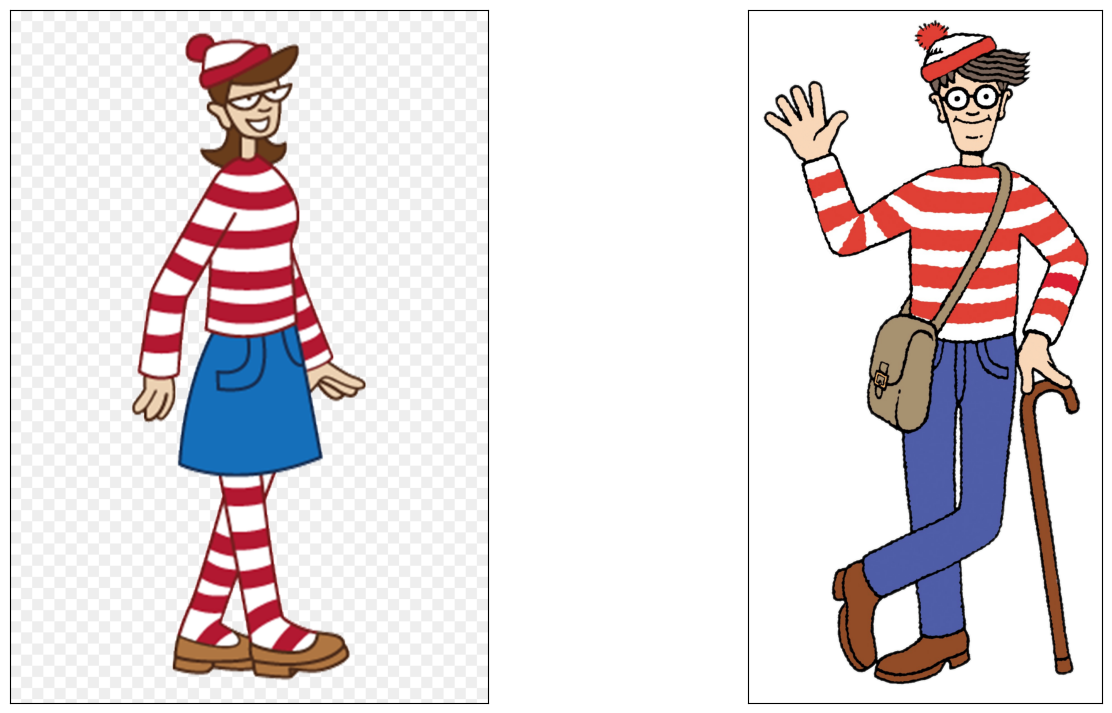

In [55]:
from llama_index.schema import ImageNode
from llama_index.response.notebook_utils import (
    display_source_node,
    display_image_uris,
)

image_results = []
MAX_RES = 5
cnt = 0
for r in retrieval_results:
    if isinstance(r.node, ImageNode):
        image_results.append(r.node.image_path)
    else:
        if cnt < MAX_RES:
            display_source_node(r)
        cnt += 1

display_image_uris(image_results, [1, 2], top_k=2)

In [57]:
retrieval_results[0].text

'The image shows a cartoon drawing of a woman, who is most likely the character Wanda from the popular children\'s book series "Where\'s Wally?" by Martin Handford. She is drawn in a simple, cartoon style with black outlines and flat colors.\n\nWanda is depicted as a young woman with brown hair and glasses. She is wearing a red and white striped top, a blue skirt, and brown shoes. She also has a red and white striped hat on her head. She is smiling and looking to the right of the frame, seemingly in a happy and carefree mood.'

In [58]:
retrieval_results[1].text

'The image shows a man standing with a cane in his left hand and his right hand raised in the air. He is wearing a red and white striped shirt, blue pants, and brown shoes. He has a brown bag hanging from his right shoulder. He is wearing glasses and a red and white hat with a pom-pom on the end. He has a friendly expression on his face.\n\nThe man is standing in a green field. There are no other people or objects in the image.\n\nThe man is likely to be Wally, also known as Waldo, from the children\'s picture book series "Where\'s Wally?" by Martin Handford. Wally is a bespectacled man who wears a red-and-white-striped shirt and a red-and-white bobble hat. He is known for being very good at hiding, and the reader is challenged to find him in each picture.'

### Testing the retrieval with a query engine

This time after the retrieval is done and retrieves a few nodes, llama_index will ask the llm to synthetise a response to the original question using the multimodal context supplied.

In [59]:
query_engine = index.as_query_engine(
    similarity_top_k=3,
)

response = query_engine.query(
    "What are the similarities between Wanda and Wally?"
)
print(response)

Wanda and Wally have several similarities. They both wear red and white striped shirts, blue pants, and brown shoes. They also wear glasses and have a friendly expression on their faces. Additionally, they both have a red and white hat, although Wanda's hat does not have a pom-pom on it. Overall, their outfits and appearances are quite similar.


## Multi-modal query engine

This time we will pass the user query, alongside the image the user has chosen as source, and then will ask if the target detected in the

['sources/beach-0.png', 'sources/snow easy-1_compressed.png', 'sources/vikings-2_compressed.png']


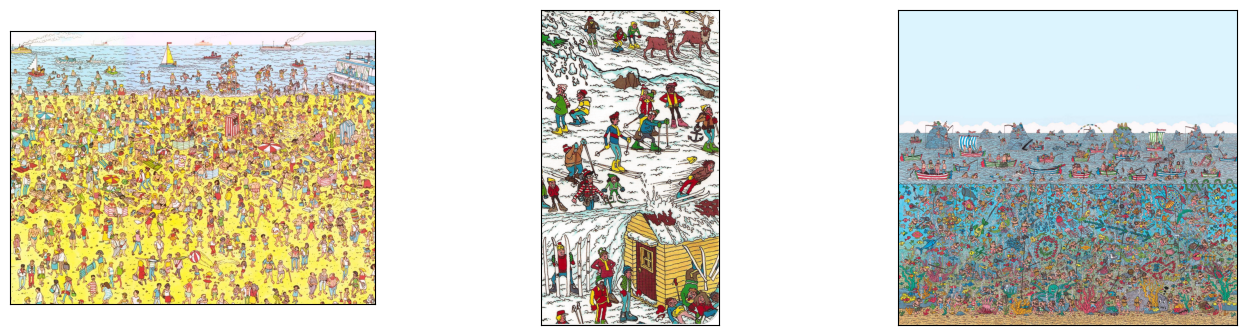

In [65]:
image_paths = [str(img_doc.image_path) for img_doc in source_image_documents]
print(image_paths)
plot_images(image_paths)

In [ ]:
query_engine.aquery

In [68]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zk5rq26t
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zk5rq26t
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=9578c6929ee5e64df990e7602fdc9db4679f3ae3adf0463c1a508f6049b3dd5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-t3zytnu1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [69]:
from llama_index.indices.multi_modal import MultiModalVectorStoreIndex

mm_index = MultiModalVectorStoreIndex.from_documents(
    documents=target_image_documents,
    # service_context=service_context,
    storage_context=storage_context,
    show_progress=True
)

Parsing nodes:   0%|          | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 162MiB/s]


Generating embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

Generating image embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [70]:
mm_query_engine = mm_index.as_query_engine(similarity_top_k=3)

In [73]:
source_image_path = source_image_documents[1].image_path

In [71]:
prompt_str = "Can you find Wanda in the image? If not, what it is that you see? if you do find Wanda, then say HOORAY!"

In [75]:
retriever = mm_index.as_retriever()

In [78]:
results = retriever.retrieve(prompt_str)


In [80]:
mm_query_engine.image_query(image_path=source_image_path, prompt_str=prompt_str)

KeyError: ignored